<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span><ul class="toc-item"><li><span><a href="#Fonctions-utilitaires" data-toc-modified-id="Fonctions-utilitaires-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Fonctions utilitaires</a></span></li></ul></li><li><span><a href="#Processing-du-corpus" data-toc-modified-id="Processing-du-corpus-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Processing du corpus</a></span></li><li><span><a href="#CountVectorizer-et-TF-IDF" data-toc-modified-id="CountVectorizer-et-TF-IDF-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>CountVectorizer et TF-IDF</a></span><ul class="toc-item"><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#CountVectorizer" data-toc-modified-id="CountVectorizer-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>CountVectorizer</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>TF-IDF</a></span></li></ul></li></ul></li><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Word2Vec</a></span><ul class="toc-item"><li><span><a href="#Création-de-la-matrice-de-représentation" data-toc-modified-id="Création-de-la-matrice-de-représentation-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Création de la matrice de représentation</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Clustering</a></span></li></ul></li><li><span><a href="#BERT,-Bidirectionnal-Encoder-Representations-and-Transformers" data-toc-modified-id="BERT,-Bidirectionnal-Encoder-Representations-and-Transformers-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>BERT, Bidirectionnal Encoder Representations and Transformers</a></span><ul class="toc-item"><li><span><a href="#Fonctions-utilitaires" data-toc-modified-id="Fonctions-utilitaires-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Fonctions utilitaires</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Clustering</a></span></li></ul></li><li><span><a href="#USE,-Universal-Sentence-Encoder" data-toc-modified-id="USE,-Universal-Sentence-Encoder-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>USE, Universal Sentence Encoder</a></span><ul class="toc-item"><li><span><a href="#Fonctions-utilitaires" data-toc-modified-id="Fonctions-utilitaires-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Fonctions utilitaires</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Clustering</a></span></li></ul></li></ul></div>

# Notebook étude de faisabilité d'un moteur de classification automatique.

Nous explorerons dans ce notebook la faisabilité d'implémentation d'un moteur de classificaiton automatique basée sur les descriptions fournies par les vendeurs.

## Imports

In [45]:
import gensim
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import backend as K
import tensorflow.keras
import tensorflow as tf
import umap.plot
import sklearn.feature_extraction.text
import sklearn.datasets
import sympy
import scipy.sparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
import ast
import umap
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import hdbscan
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import transformers
from transformers import *
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Nous nous baserons sur le travail déjà effectué fournis. 

### Fonctions utilitaires

In [46]:
# Liste des stopswords fournis par nltk plus certaines marques de ponctuations.
stop_w = list(set(stopwords.words('english'))) + \
    ['[', ']', ',', '.', ':', '?', '(', ')']


def tokenizer_fct(sentence):
    """
    Fonction qui tokenise la phrase fournie.

    Un tokenizer décompose un texte en blocs d'informations 
    qui peuvent être considérés comme des éléments discrets.

    Parameters:
    sentence (str): Le texte à tokeniser

    Returns:
    word_tokens list(str): Le texte tokenisé, sans ponctuation ni autre signe

    """
    sentence_clean = sentence.replace(
        '-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens


def stop_word_filter_fct(list_words):
    """
    Fonction qui filtre les stopwords.

    La fonction choisie les mots qui ne sont 
    pas des stopwords et les enregistre dans une liste.

    Parameters:
    list_words (list(str)): Le texte à filtrer

    Returns:
    filtered_w2 list(str): Le texte filtré, sans stopwords

    """
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2


def lower_start_fct(list_words):
    """
    Fonction qui filtre les @ et http.

    La fonction choisie les mots qui ne sont 
    pas @ et http et les enregistre dans une liste.

    Parameters:
    list_words (list(str)): Le texte à filtrer

    Returns:
    lw list(str): Le texte filtré, sans stopwords

    """
    lw = [w.lower() for w in list_words if (not w.startswith("@"))
          #                                   and (not w.startswith("#"))
          and (not w.startswith("http"))]
    return lw


def lemma_fct(list_words):
    """
    Fonction qui lemmatise la phrase fournie.

    Un lemmatizer décompose les mots d'une phrase
    en leur forme la plus simple. L'indicatif pour
    les verbes, les noms communs sans être accordés etc.

    Parameters:
    list_words (list(str)): Le texte à lemmatiser

    Returns:
    list(str): Le texte lemmatisé

    """
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w


def transform_bow_fct(desc_text):
    """
    Fonction qui créé un bag of words avec la phrase fournie.

    La tokenisation en premier, ensuite le filtrage, sans lemmatisation.

    Parameters:
    desc_text (str): Le texte à lemmatiser

    Returns:
    transf_desc_textstr list(str): Le texte lemmatisé

    """
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    #lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


def transform_bow_lem_fct(desc_text):
    """
    Fonction qui créé un bag of words avec la phrase fournie.

    La tokenisation en premier, ensuite le filtrage, avec lemmatisation.

    Parameters:
    desc_text (str): Le texte à lemmatiser

    Returns:
    transf_desc_textstr list(str): Le texte lemmatisé

    """
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text


def transform_dl_fct(desc_text):
    """
    Fonction qui process la phrase fournie pour un analyse avec une modèle deep learning.

    La tokenisation en premier, sans filtrage de stopwords, sans lemmatisation.

    Parameters:
    desc_text (str): Le texte à lemmatiser

    Returns:
    transf_desc_textstr list(str): Le texte lemmatisé

    """
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


def ARI_fct_KMeans(features):
    """
    Détermination des clusters et calcul ARI entre vrais catégories et n° de clusters
    Réduction dimensionelle avec umap.

    Calcul des clusters avec un KMeans et 
    calcul du score ARI entre les vrais catégories et les clusters.
    Réduction dimensionelle avec umap pour projeter les résultats en 2d.

    Parameters:
    features (array): Les features représentant les corpus(Countvectorizer, Tf_idf, Word2Vec, BERT...)

    Returns:
    ARI (float): Le score ARI, arrondi à 10e-4
    X_umap (array(float)): La projection qui est calculée par umap
    cls.labels_ (array(int)): L'array qui contient les labels des clusters

    """
    time1 = time.time()
    num_labels = len(l_cat)
    cls = cluster.KMeans(n_clusters=num_labels)
    cls.fit(features)
    X_umap = umap.UMAP(n_components=2, metric="cosine").fit_transform(features)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_umap, cls.labels_


def ARI_fct_UMAP_KMeans(features):
    """
    Détermination des clusters et calcul ARI entre vrais catégories et n° de clusters
    Réduction dimensionelle avec umap.

    Réduction dimensionelle avec umap(n_components=4)
    et calcul des clusters avec un KMeans et
    calcul du score ARI entre les vrais catégories et les clusters.
    Réduction dimensionelle avec umap pour projeter les résultats en 2d.

    Parameters:
    features (array): Les features représentant les corpus (Countvectorizer, Tf_idf, Word2Vec, BERT...)

    Returns:
    ARI (float): Le score ARI, arrondi à 10e-4
    X_umap (array(float)): La projection qui est calculée par umap
    cls.labels_ (array(int)): L'array qui contient les labels des clusters

    """
    time1 = time.time()
    num_labels = len(l_cat)
    X_umap = umap.UMAP(n_components=4,
                       n_neighbors=25).fit_transform(features)
    cls = cluster.KMeans(n_clusters=num_labels)
    cls.fit(X_umap)
    X_umap = umap.UMAP(n_components=2, metric="cosine").fit_transform(X_umap)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_umap, cls.labels_


def ARI_fct_UMAP_Dendro(features):
    """
    Détermination des clusters et calcul ARI entre vrais catégories et n° de clusters
    Réduction dimensionelle avec umap.

    Réduction dimensionelle avec umap(n_components=4)
    et calcul des clusters avec AgglomerativeClustering et
    calcul du score ARI entre les vrais catégories et les clusters.
    Réduction dimensionelle avec umap pour projeter les résultats en 2d.

    Parameters:
    features (array): Les features représentant les corpus (Countvectorizer, Tf_idf, Word2Vec, BERT...)

    Returns:
    ARI (float): Le score ARI, arrondi à 10e-4
    X_umap (array(float)): La projection qui est calculée par umap
    cls.labels_ (array(int)): L'array qui contient les labels des clusters

    """
    time1 = time.time()
    num_labels = len(l_cat)
    X_umap = umap.UMAP(n_components=4,
                       n_neighbors=25).fit_transform(features)
    cls = cluster.AgglomerativeClustering(n_clusters=num_labels)
    cls.fit(X_umap)
    X_umap = umap.UMAP(n_components=2, metric="cosine").fit_transform(X_umap)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_umap, cls.labels_


def ARI_fct_HDBSCAN(features):
    """
    Détermination des clusters et calcul ARI entre vrais catégories et n° de clusters
    Réduction dimensionelle avec umap.

    Calcul des clusters avec un HDBSCAN et
    calcul du score ARI entre les vrais catégories et les clusters.
    Réduction dimensionelle avec umap pour projeter les résultats en 2d.

    Parameters:
    features (array): Les features représentant les corpus (Countvectorizer, Tf_idf, Word2Vec, BERT...)

    Returns:
    ARI (float): Le score ARI, arrondi à 10e-4
    X_umap (array(float)): La projection qui est calculée par umap
    random_search.best_estimator_.labels_ (array(int)): L'array qui contient les labels des clusters

    """
    time1 = time.time()
    num_labels = len(l_cat)
    hdb = hdbscan.HDBSCAN(gen_min_span_tree=True,
                          min_samples=20, min_cluster_size=20)
    hdb.fit(features)
    X_umap = umap.UMAP(n_components=2, metric="cosine").fit_transform(features)
    ARI = np.round(metrics.adjusted_rand_score(
        y_cat_num, hdb.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_umap, hdb.labels_


def ARI_fct_UMAP_HDBSCAN(features):
    """
    Détermination des clusters et calcul ARI entre vrais catégories et n° de clusters
    Réduction dimensionelle avec umap.

    Réduction dimensionelle avec umap(n_components=4)
    et calcul des clusters avec HDBSCAN et
    calcul du score ARI entre les vrais catégories et les clusters.
    Réduction dimensionelle avec umap pour projeter les résultats en 2d.

    Parameters:
    features (array): Les features représentant les corpus (Countvectorizer, Tf_idf, Word2Vec, BERT...)

    Returns:
    ARI (float): Le score ARI, arrondi à 10e-4
    X_umap (array(float)): La projection qui est calculée par umap
    random_search.best_estimator_.labels_ (array(int)): L'array qui contient les labels des clusters

    """
    time1 = time.time()
    mapper = umap.UMAP(
        n_neighbors=25,
        n_components=4, metric="cosine").fit(features)
    num_labels = len(l_cat)
    X_umap = mapper.fit_transform(features)
    hdb = hdbscan.HDBSCAN(gen_min_span_tree=True,
                          min_samples=20, min_cluster_size=20)
    hdb.fit(X_umap)
    X_umap = umap.UMAP(n_components=2, metric="cosine").fit_transform(X_umap)
    ARI = np.round(metrics.adjusted_rand_score(
        y_cat_num, hdb.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)
    return ARI, X_umap, hdb.labels_


def umap_visu_fct(X_umap, y_cat_num, labels, ARI):
    """
    Affiche la aisualisation de umap selon les vraies catégories et selon les clusters.

    Scatter plot coloré avec les vrais clusters, et les clusters prédits.

    Parameters:
    X_umap (array): La projection qui est calculée par umap
    y_cat_num (list(int)): Le numéro des catégories
    labels (array): L'array qui contient les labels des clusters
    ARI float: Le score ARI, arrondi à 10e-4 

    Returns: 
    None
    """
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)

    scatter = sns.scatterplot(
        data=X_umap, x=X_umap[:, 0], y=X_umap[:, 1], hue=y_cat_num, palette='Paired')
    plt.title('Représentation des items par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = sns.scatterplot(
        data=X_umap, x=X_umap[:, 0], y=X_umap[:, 1], hue=labels, palette='Paired')
    plt.title('Représentation items par clusters')

    plt.show()

## Processing du corpus

Lecture du csv.

In [47]:
data_T0 = pd.read_csv(
    '/Users/loicvalenti/Library/Mobile Documents/com~apple~CloudDocs/Formation Data Science/PROJET 6/Flipkart/flipkart_com-ecommerce_sample_1050.csv')

Nous pouvons maintenant utiliser les fonctions fournis pour tokeniser, lemmatiser, et enlever les stopswords, pour traiter chacune des descriptions.

In [48]:
data_T = pd.DataFrame()
data_T['sentence_bow'] = data_T0['description'].apply(
    lambda x: transform_bow_fct(x))
data_T['sentence_bow_lem'] = data_T0['description'].apply(
    lambda x: transform_bow_lem_fct(x))
data_T['sentence_dl'] = data_T0['description'].apply(
    lambda x: transform_dl_fct(x))
data_T.shape

(1050, 3)

Nous pouvons maintenant extraire du csv les catégories réelles. 

In [49]:
category_levels = (data_T0["product_category_tree"]
                   .apply(lambda x: ast.literal_eval(x))
                   .apply(lambda x: x[0].replace("\\", "").replace("'", "").split(" >> "))
                   .apply(pd.Series)
                   .rename(columns=lambda x: "level_"+str(x)))
df = pd.concat([category_levels, data_T0], axis=1)

Nous pouvons selectionner la première catégorie à considérer comme catégories vraies.

In [50]:
data_T0 = df.drop(columns=["level_1", "level_2",
                  "level_3", "level_4", "level_5", "level_6"])

In [51]:
data_T0.level_0.value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: level_0, dtype: int64

Les différentes catégories sont équilibrées.

In [52]:
l_cat = list(set(data_T0["level_0"]))
y_cat_num = [(l_cat.index(data_T0.iloc[i]['level_0']))
             for i in range(len(data_T0))]

## CountVectorizer et TF-IDF

Nous allons procéder à la création du bag of words, avec deux manières différentes mais similaires.

In [53]:
# création du bag of words (CountVectorizer et Tf-idf)

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)


feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])
ctf_transform = ctf.transform(data_T[feat])

### Clustering

#### CountVectorizer

CountVectorizer, KMeans: 
-----------------
ARI :  0.1451 time :  2.0


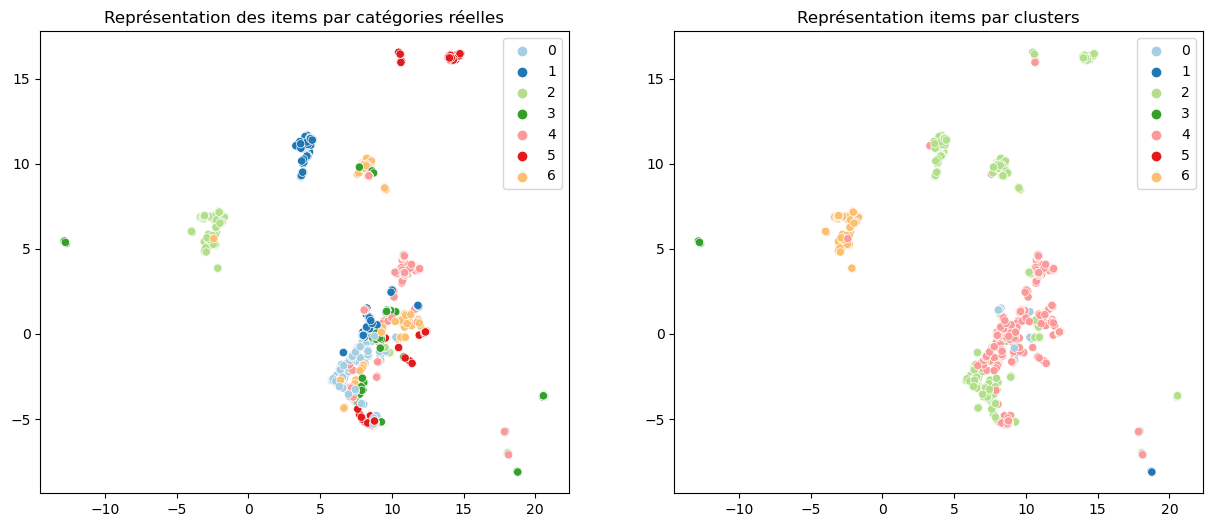

CountVectorizer, UMAP_KMeans: 
-----------------
ARI :  0.2489 time :  4.0


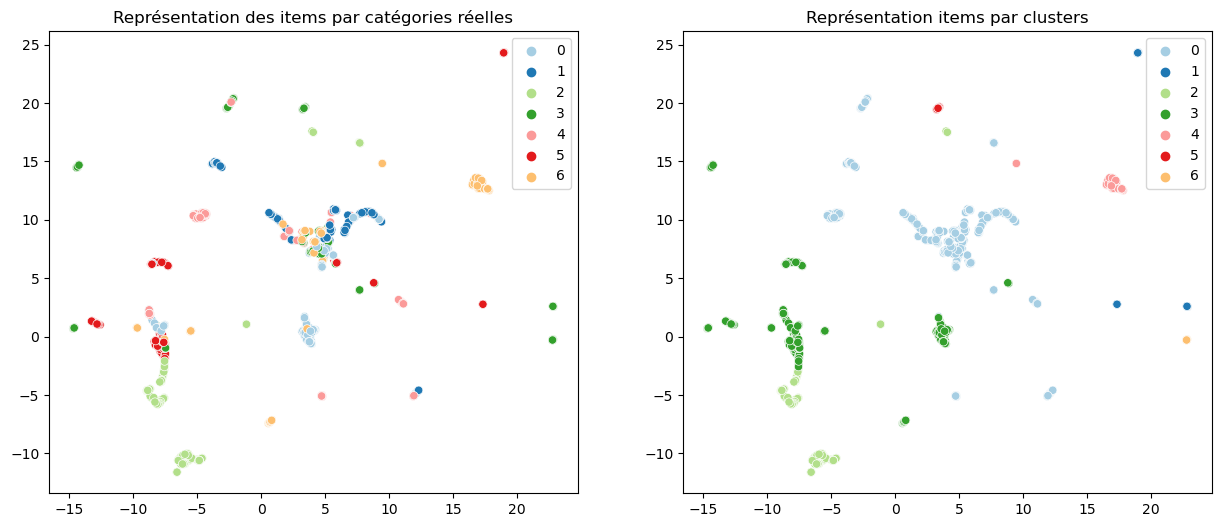

CountVectorizer, Dendro: 
-----------------
ARI :  0.17 time :  4.0


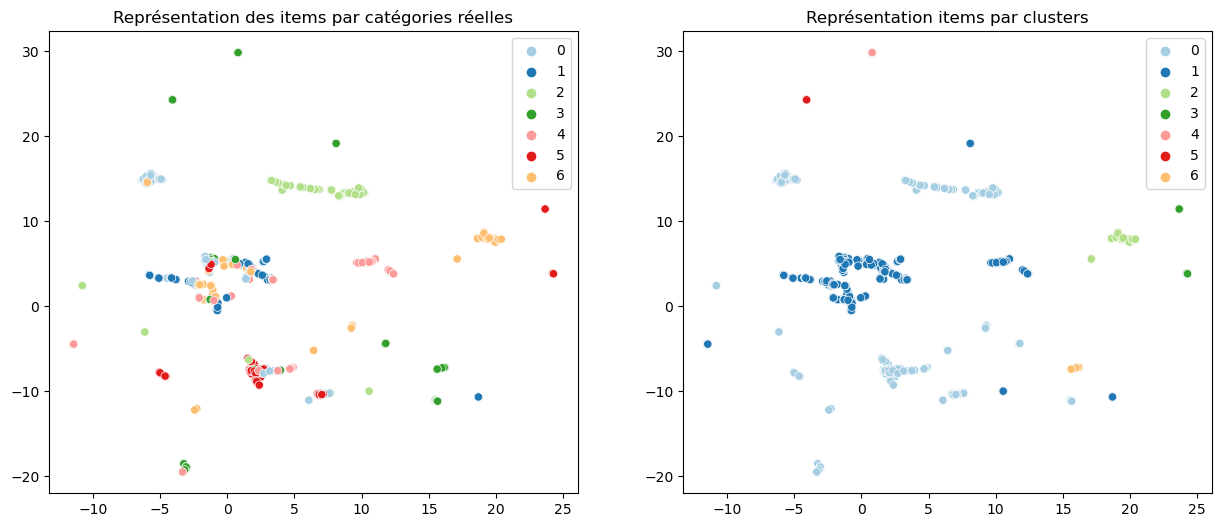

CountVectorizer, HDBSCAN: 
-----------------
ARI :  0.017 time :  2.0


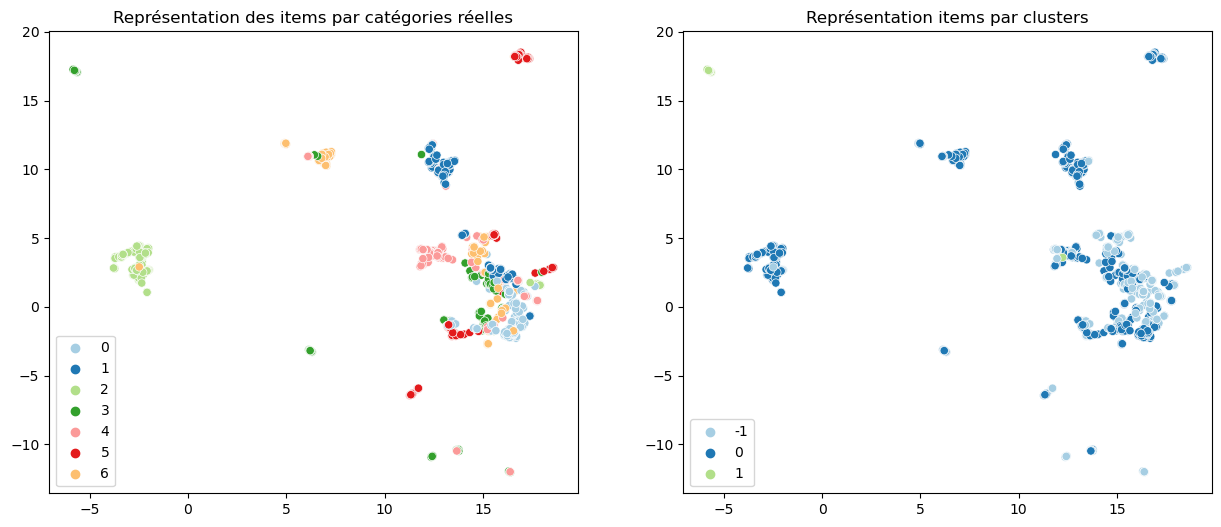

CountVectorizer, UMAP HDBSCAN: 
-----------------
ARI :  0.2056 time :  5.0


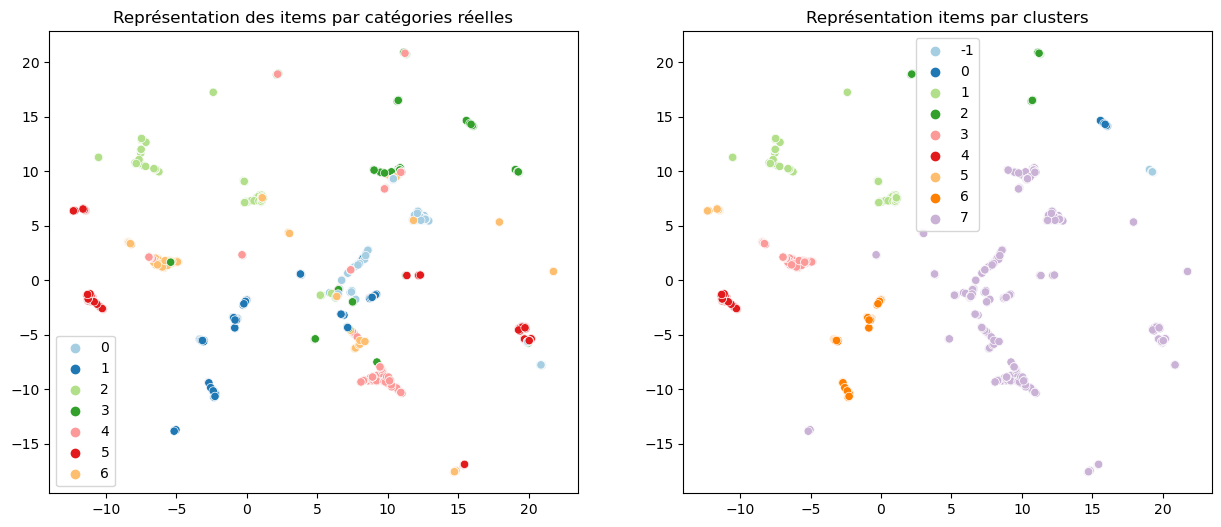

In [54]:
print("CountVectorizer, KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_KMeans(cv_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("CountVectorizer, UMAP_KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_KMeans(cv_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("CountVectorizer, Dendro: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_Dendro(cv_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("CountVectorizer, HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_HDBSCAN(cv_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("CountVectorizer, UMAP HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_HDBSCAN(cv_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

#### TF-IDF

TF-IDF, KMeans: 
-----------------
ARI :  0.2998 time :  2.0


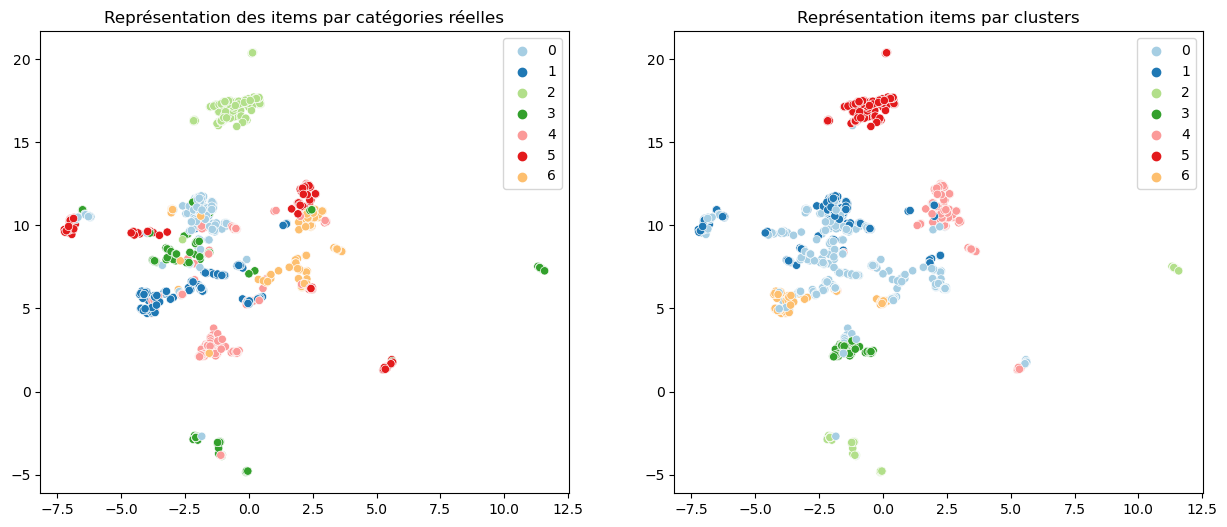

TF-IDF, UMAP_KMeans: 
-----------------
ARI :  0.4899 time :  3.0


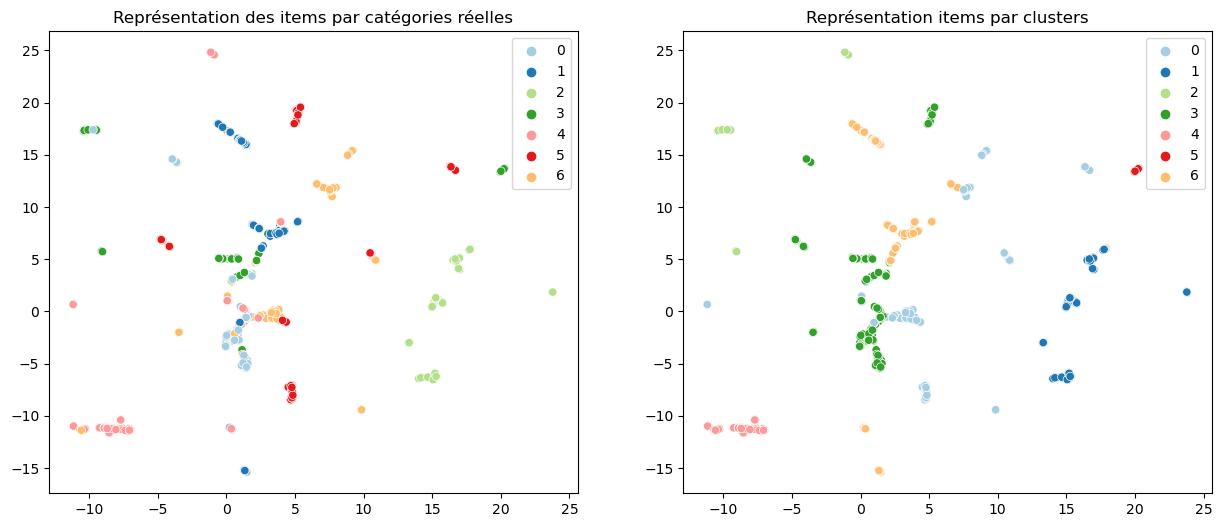

TF-IDF, Dendro: 
-----------------
ARI :  0.4715 time :  4.0


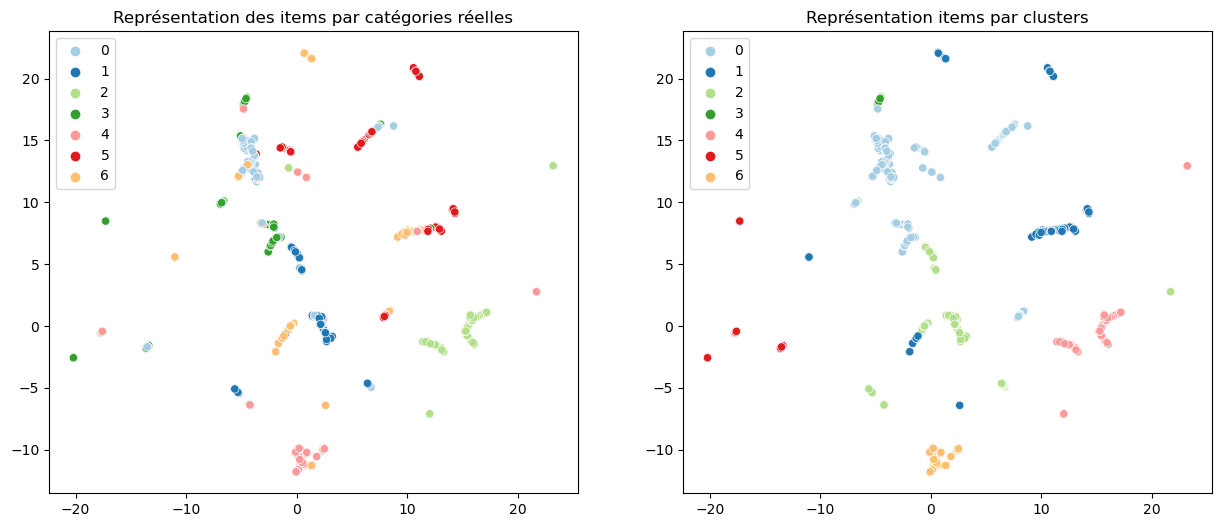

TF-IDF, HDBSCAN: 
-----------------
ARI :  0.0408 time :  2.0


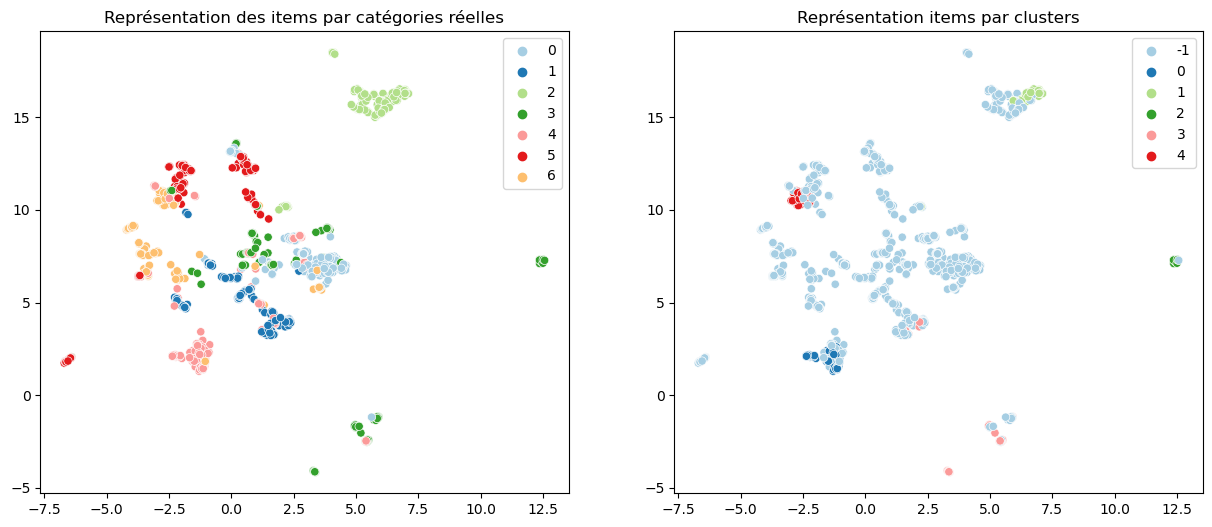

TF-IDF, UMAP HDBSCAN: 
-----------------
ARI :  0.4731 time :  5.0


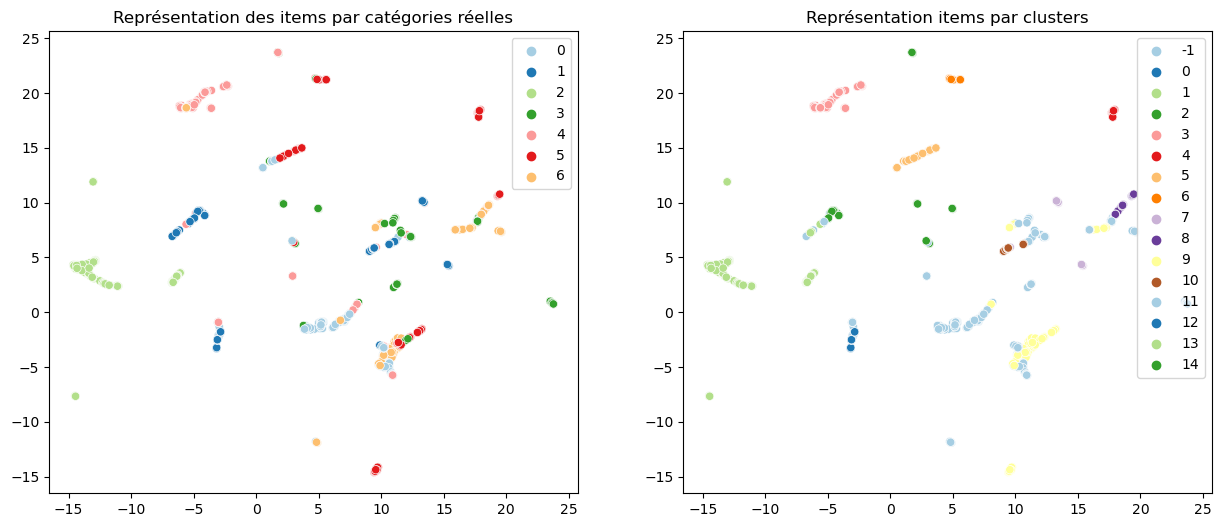

In [55]:
print("TF-IDF, KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_KMeans(ctf_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("TF-IDF, UMAP_KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_KMeans(ctf_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("TF-IDF, Dendro: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_Dendro(ctf_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("TF-IDF, HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_HDBSCAN(ctf_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("TF-IDF, UMAP HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_HDBSCAN(ctf_transform)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

## Word2Vec

### Création de la matrice de représentation

In [56]:
w2v_size = 1000
w2v_window = 10
w2v_min_count = 25
w2v_epochs = 100
maxlen = 15  # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [57]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(
    sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 414
Word2Vec trained


In [58]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post')

num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


In [59]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 1000
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  0.0879
Embedding matrix: (4713, 1000)


In [60]:
# Création du modèle

input = Input(shape=(len(x_sentences), maxlen), dtype='float64')
word_input = Input(shape=(maxlen,), dtype='float64')
word_embedding = Embedding(input_dim=vocab_size,
                           output_dim=w2v_size,
                           weights=[embedding_matrix],
                           input_length=maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 15, 1000)          4713000   
                                                                 
 global_average_pooling1d_2   (None, 1000)             0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 4,713,000
Trainable params: 4,713,000
Non-trainable params: 0
_________________________________________________________________


In [61]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 596us/step


(1050, 1000)

### Clustering

Word2Vec, KMeans: 
-----------------
ARI :  0.2258 time :  4.0


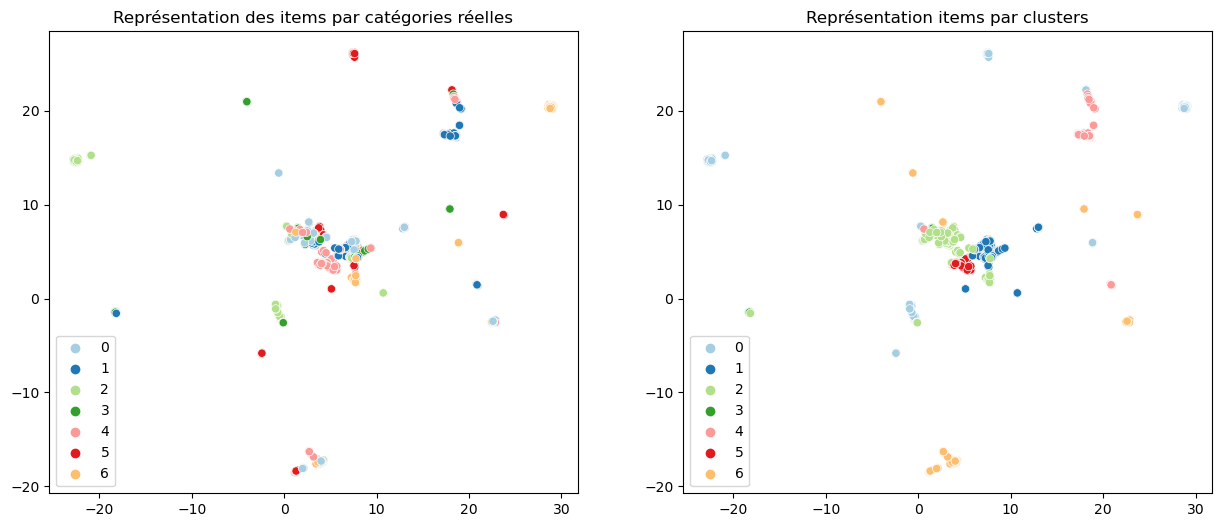

Word2Vec, UMAP_KMeans: 
-----------------
ARI :  0.1463 time :  5.0


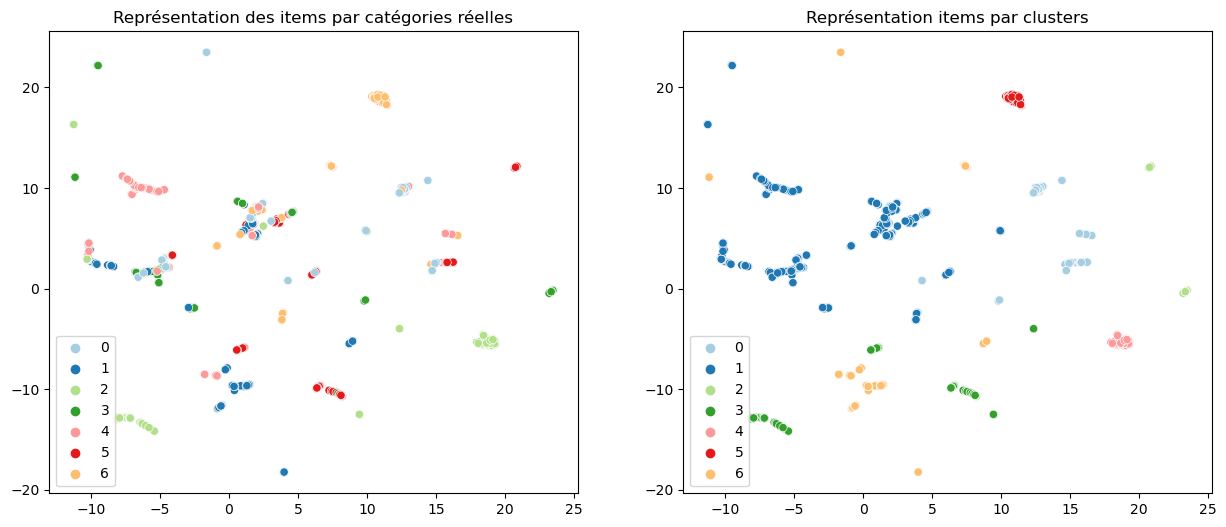

Word2Vec, Dendro: 
-----------------
ARI :  0.1448 time :  5.0


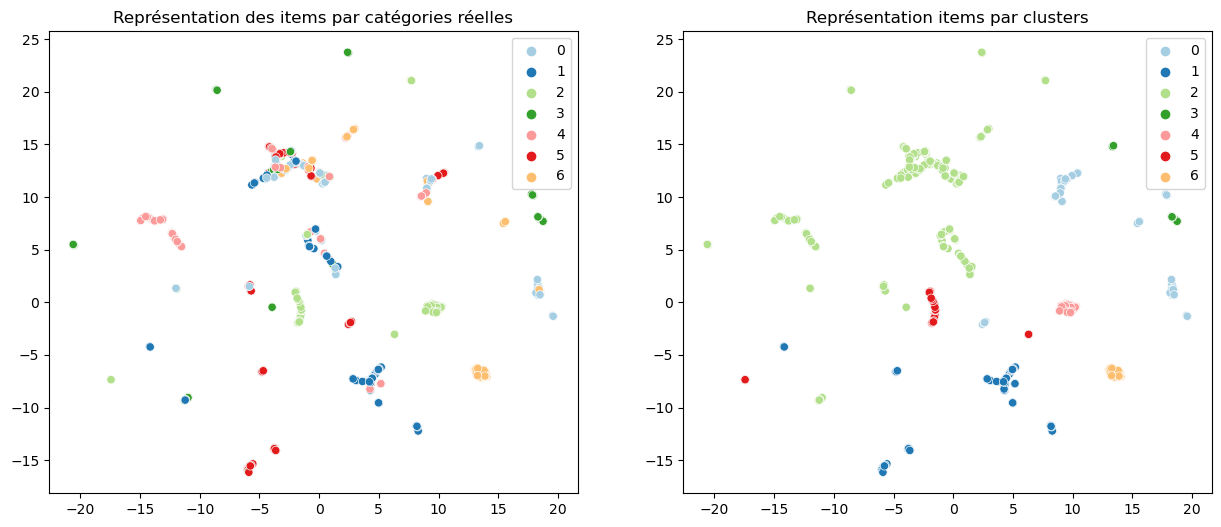

Word2Vec, HDBSCAN: 
-----------------
ARI :  0.1376 time :  4.0


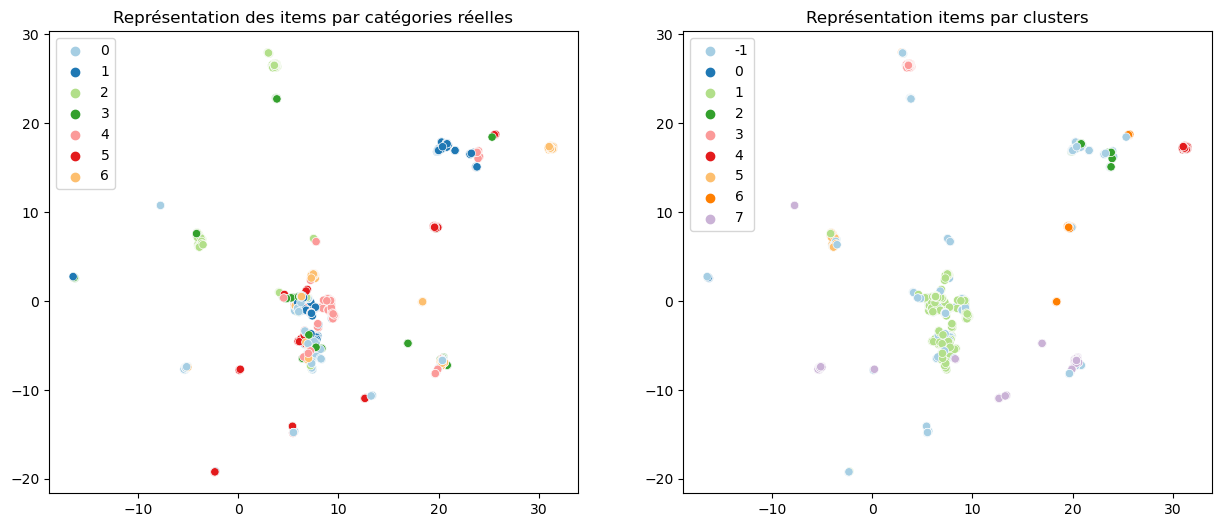

Word2Vec, UMAP HDBSCAN: 
-----------------
ARI :  0.2591 time :  9.0


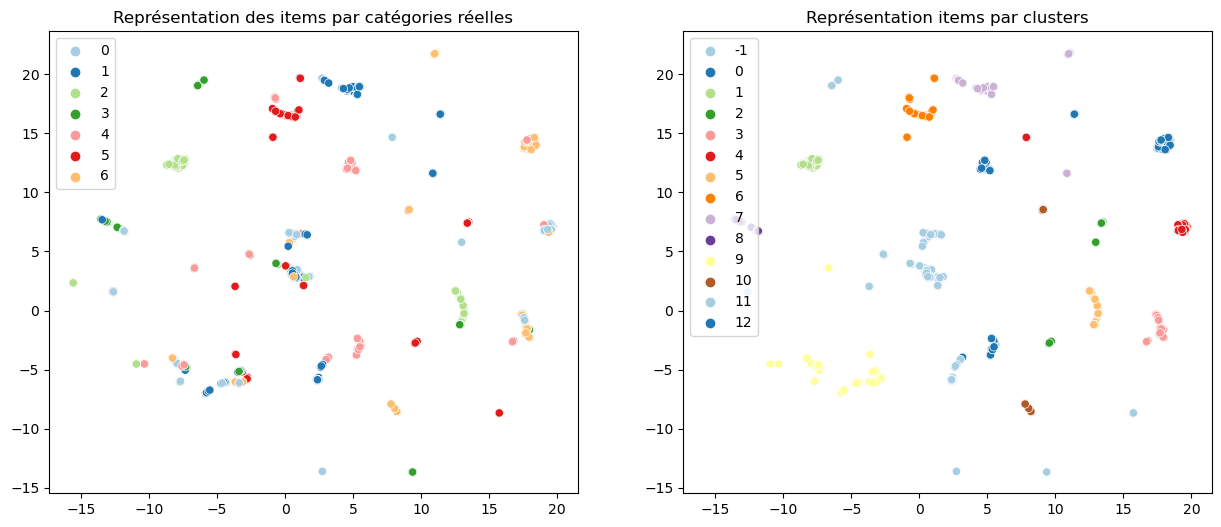

In [62]:
print("Word2Vec, KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_KMeans(embeddings)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("Word2Vec, UMAP_KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_KMeans(embeddings)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("Word2Vec, Dendro: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_Dendro(embeddings)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("Word2Vec, HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_HDBSCAN(embeddings)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("Word2Vec, UMAP HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_HDBSCAN(embeddings)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

## BERT, Bidirectionnal Encoder Representations and Transformers

### Fonctions utilitaires

In [65]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length):
    """
    Détermination des clusters et calcul ARI entre vrais catégories et n° de clusters
    Réduction dimensionelle avec umap.

    Calcul des clusters avec un KMeans et 
    calcul du score ARI entre les vrais catégories et les clusters.
    Réduction dimensionelle avec umap pour projeter les résultats en 2d.

    Parameters:
    sentences (array): Les features représentant les corpus(Countvectorizer, Tf_idf, Word2Vec, BERT...)
    bert_tokenizer (array): Le tokeniser fourni par BERT sur HuggingFace
    max_length (int): Taille maximale des sentences

    Returns:
    input_ids (float): Le score ARI, arrondi à 10e-4
    token_type_ids (array(float)): La projection qui est calculée par umap
    attention_mask (array(int)): L'array qui contient les labels des clusters
    bert_inp_tot (array(int)): L'array qui contient les labels des clusters

    """
    input_ids = []
    token_type_ids = []
    attention_mask = []
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens=True,
                                              max_length=max_length,
                                              padding='max_length',
                                              return_attention_mask=True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf", )

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF'):
    """
    Détermination des features extraites par le model de BERT choisi.

    Parameters:
    model (array): Le modèle de BERT choisi
    model_type (array): Le tokeniser fourni par BERT sur HuggingFace
    sentences (array): Les phrases utilisées pour l'entrainement
    max_length (int): Taille maximale des sentences
    b_size (int): Batch size

    Returns:
    features_bert (float): Les features extraites
    last_hidden_states_tot (array(float)): La dernière couche du modèle

    """
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                               bert_tokenizer, max_length)

        if mode == 'HF':    # Bert HuggingFace
            outputs = model.predict(
                [input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode == 'TFhub':  # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids": input_ids,
                                 "input_mask": attention_mask,
                                 "input_type_ids": token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step == 0:
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else:
            last_hidden_states_tot = np.concatenate(
                (last_hidden_states_tot, last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1, 0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

In [66]:
max_length = 20
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='HF')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/loicvalenti/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/bert-ba

1/1 [==============================] - 0s 323ms/step
temps traitement :  39.0


### Clustering

BERT, KMeans: 
-----------------
ARI :  0.3326 time :  3.0


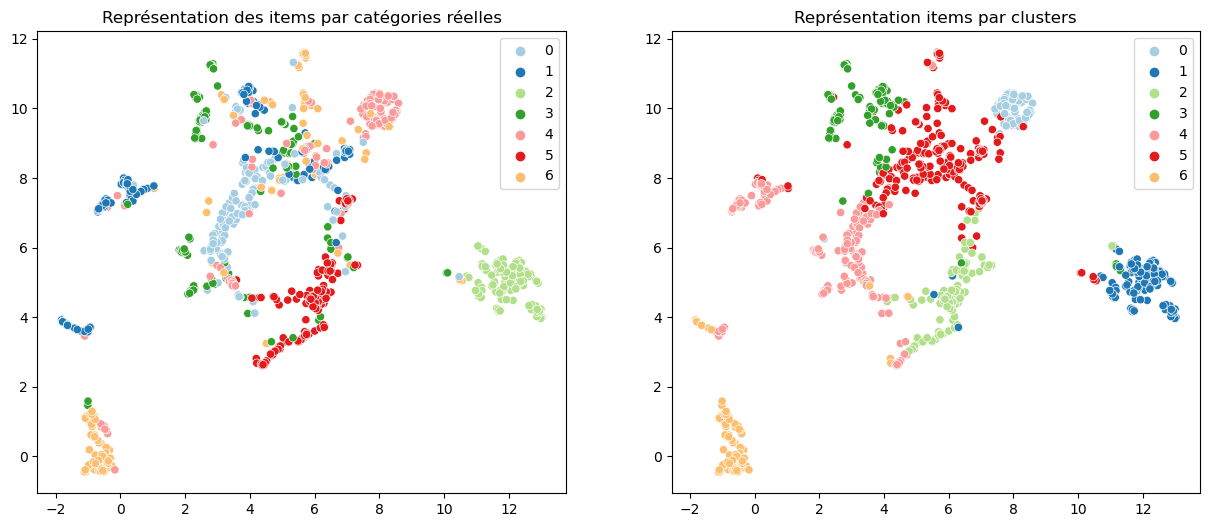

BERT, UMAP_KMeans: 
-----------------
ARI :  0.3923 time :  4.0


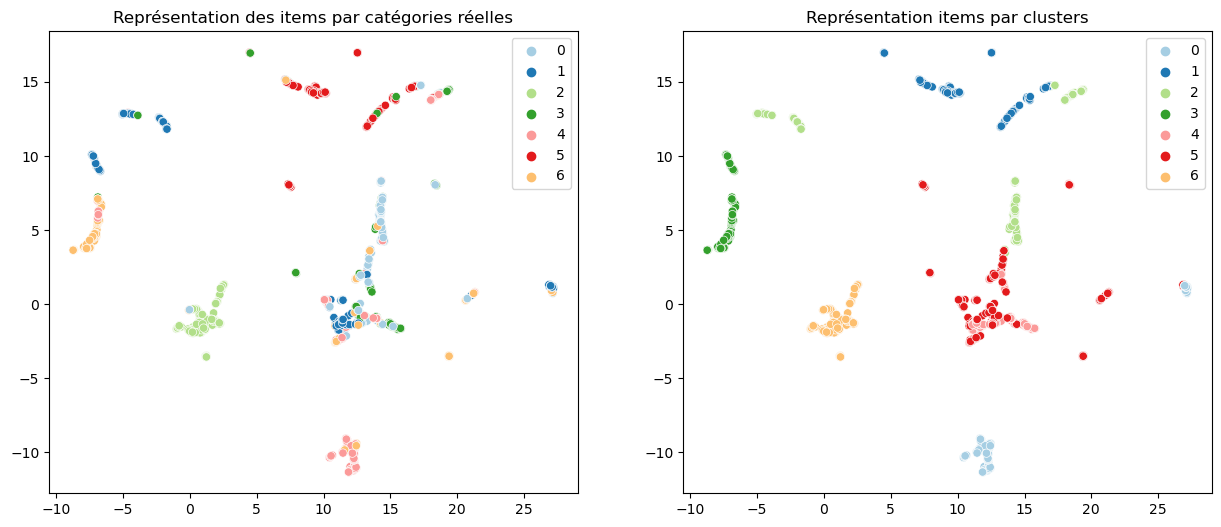

BERT, Dendro: 
-----------------
ARI :  0.3842 time :  4.0


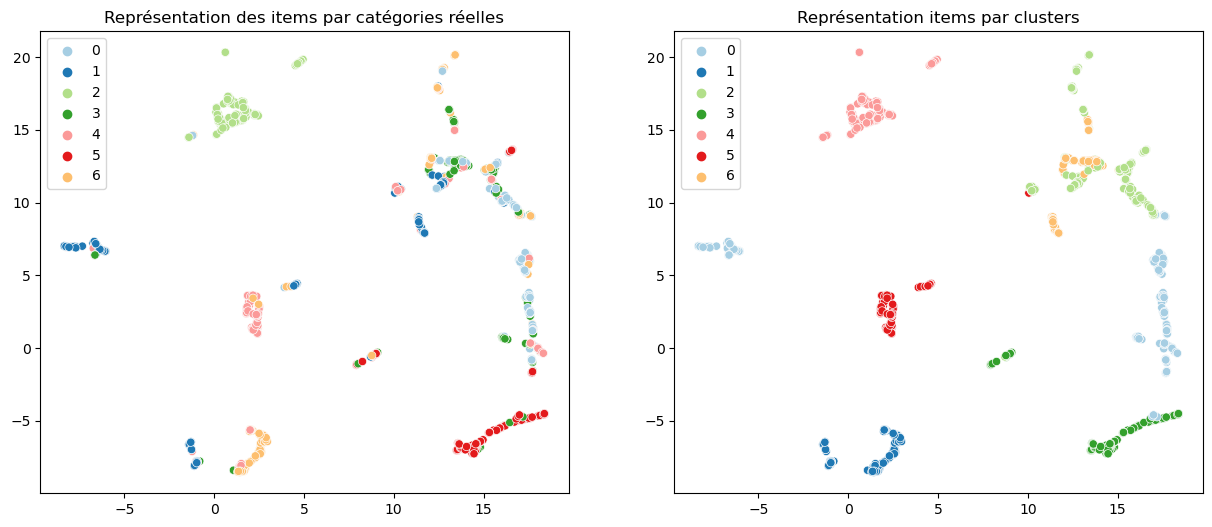

BERT, HDBSCAN: 
-----------------
ARI :  0.0321 time :  4.0


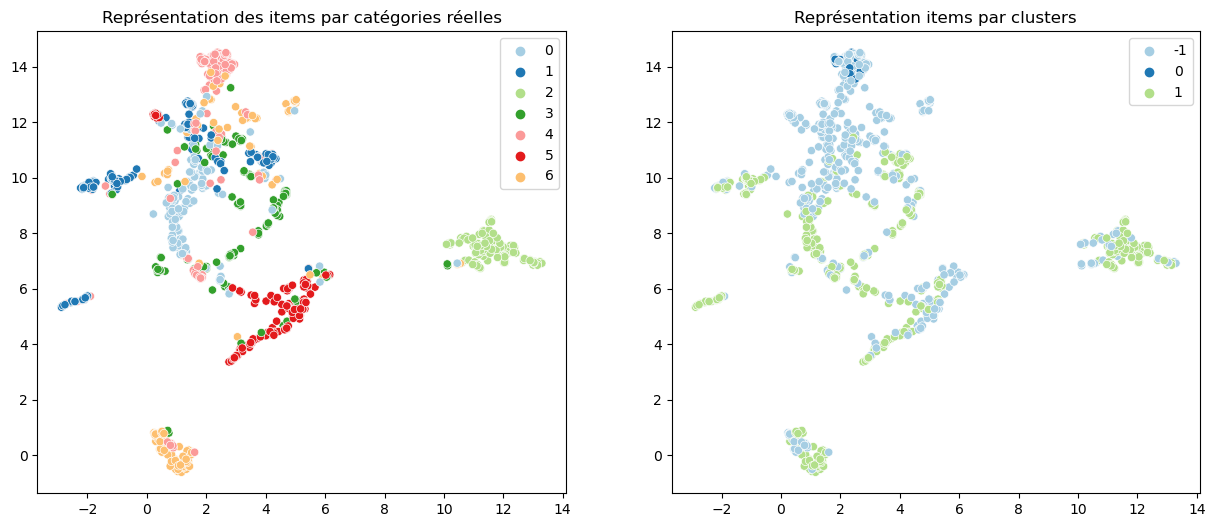

BERT, UMAP HDBSCAN: 
-----------------
ARI :  0.1443 time :  7.0


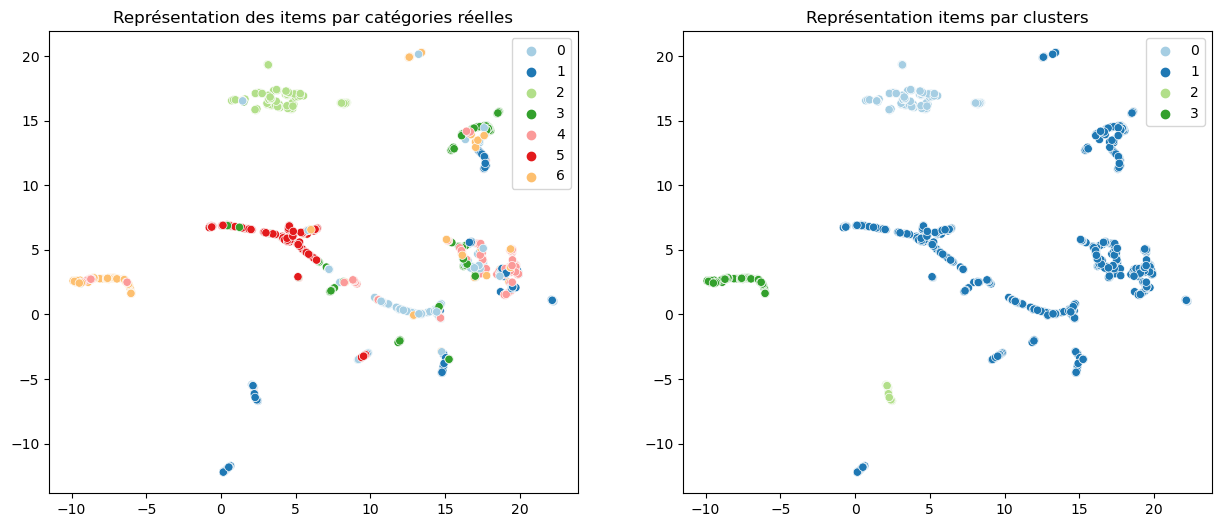

In [67]:
print("BERT, KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_KMeans(features_bert)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("BERT, UMAP_KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_KMeans(features_bert)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("BERT, Dendro: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_Dendro(features_bert)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("BERT, HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_HDBSCAN(features_bert)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("BERT, UMAP HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_HDBSCAN(features_bert)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

## USE, Universal Sentence Encoder

### Fonctions utilitaires

In [68]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


def feature_USE_fct(sentences, b_size):
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size):
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step == 0:
            features = feat
        else:
            features = np.concatenate((features, feat))

    time2 = np.round(time.time() - time1, 0)
    return features


In [69]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()
features_USE = feature_USE_fct(sentences, batch_size)

### Clustering

USE, KMeans: 
-----------------
ARI :  0.2666 time :  2.0


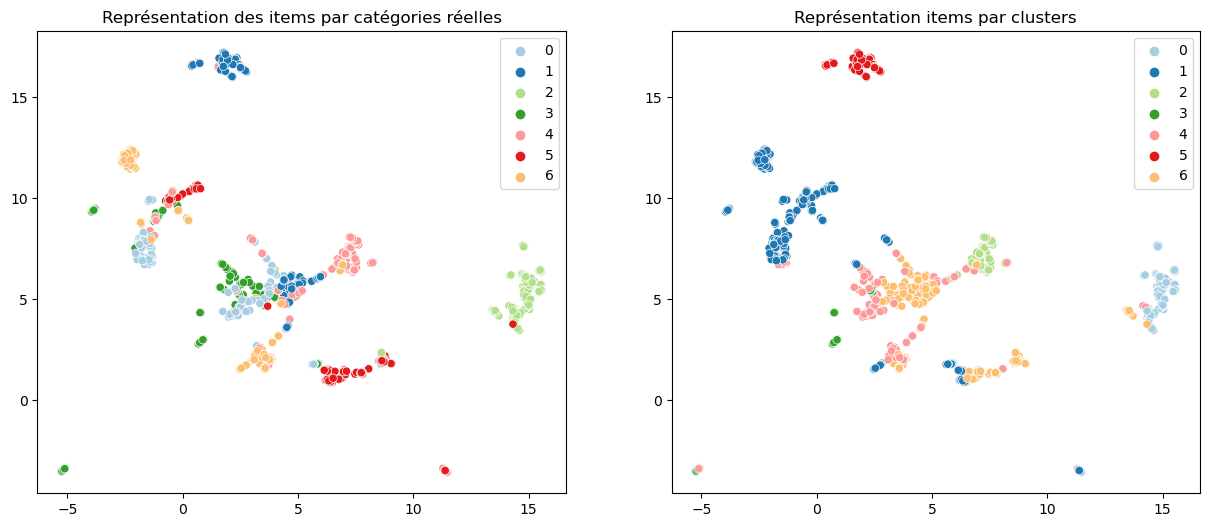

USE, UMAP_KMeans: 
-----------------
ARI :  0.3923 time :  4.0


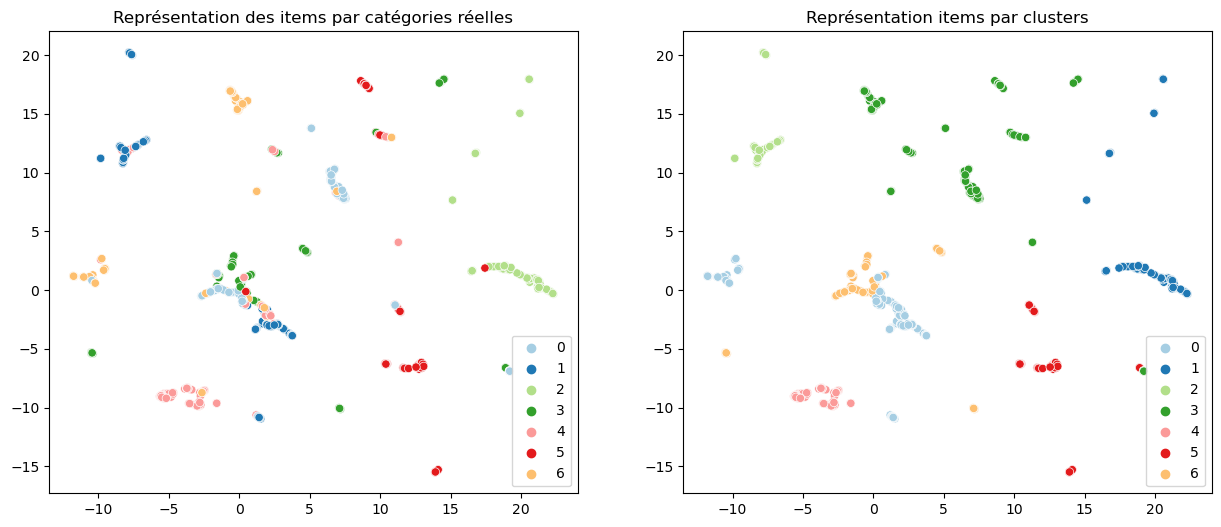

USE, Dendro: 
-----------------
ARI :  0.3718 time :  4.0


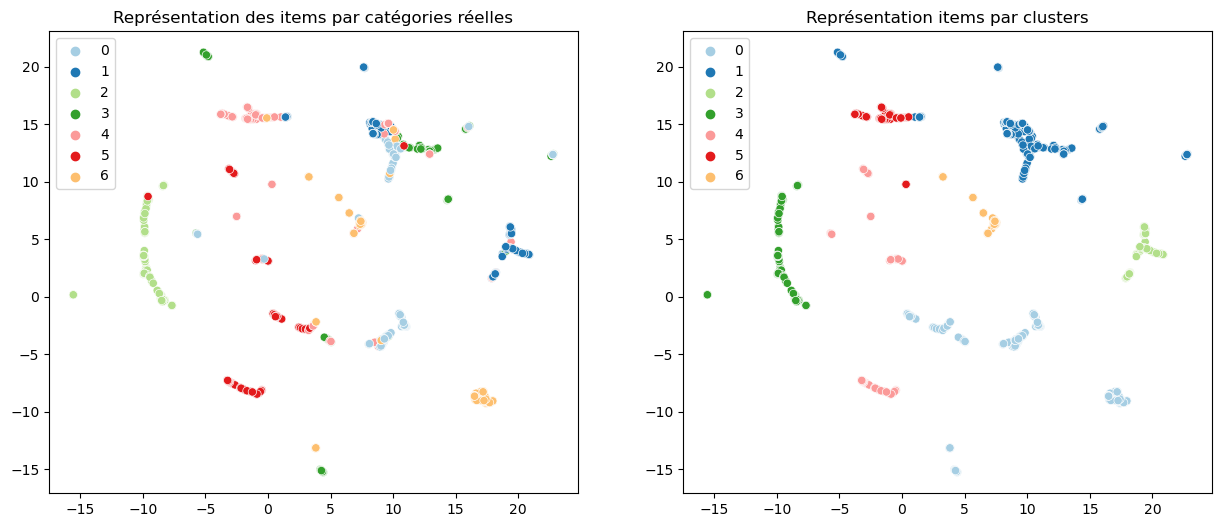

USE, HDBSCAN: 
-----------------
ARI :  0.0793 time :  3.0


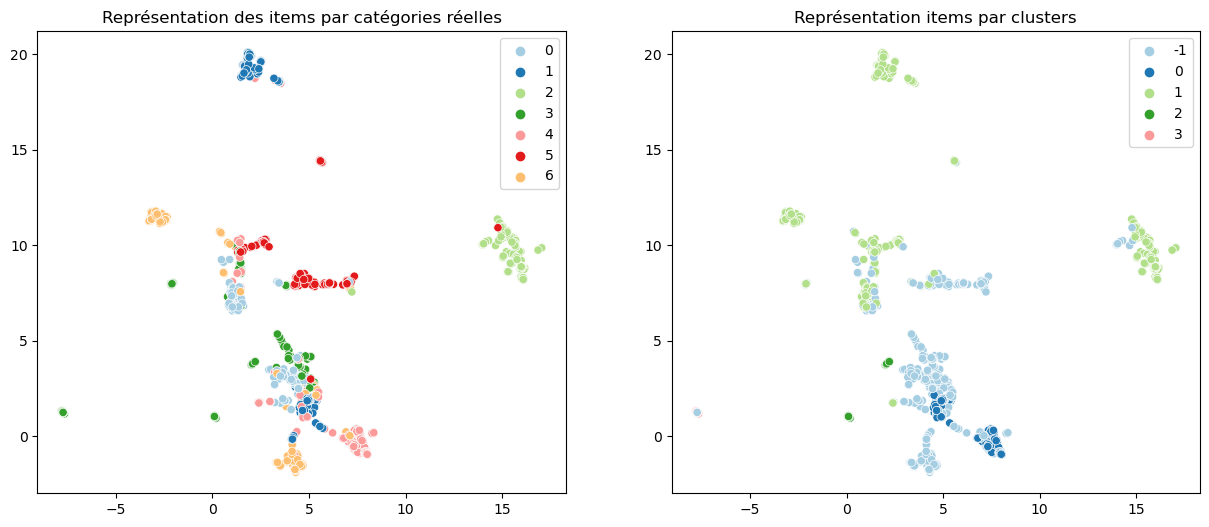

USE, UMAP HDBSCAN: 
-----------------
ARI :  0.3083 time :  6.0


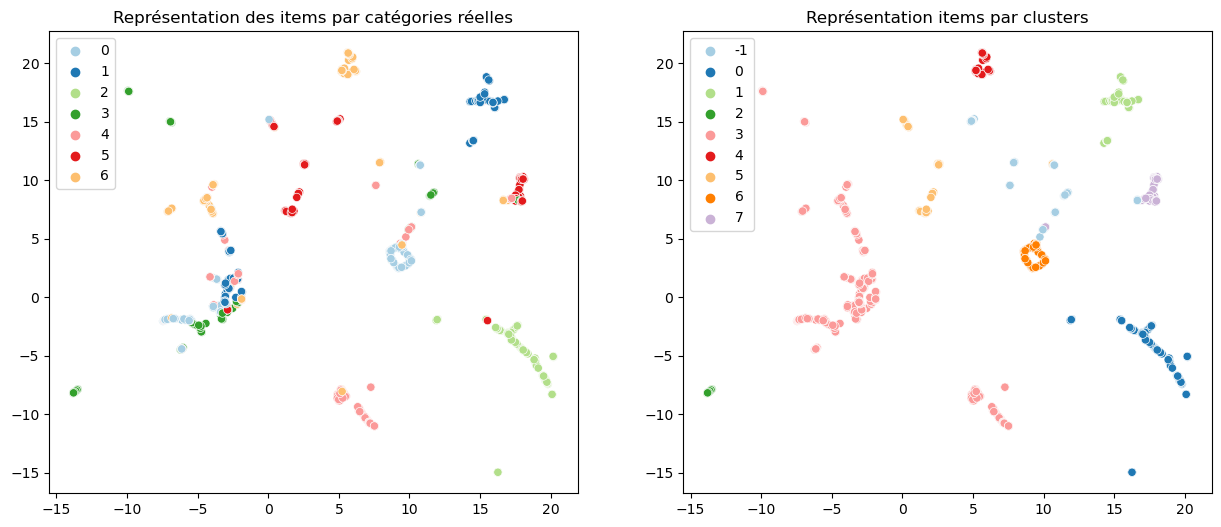

In [70]:
print("USE, KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_KMeans(features_USE)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("USE, UMAP_KMeans: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_KMeans(features_USE)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("USE, Dendro: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_Dendro(features_USE)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("USE, HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_HDBSCAN(features_USE)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)

print("USE, UMAP HDBSCAN: ")
print("-----------------")
ARI, X_umap, labels = ARI_fct_UMAP_HDBSCAN(features_USE)
umap_visu_fct(X_umap, y_cat_num, labels, ARI)